In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn import metrics
import lightgbm as lgb

sys.path.append('../')
from pipelines import main
import pipeline_config as cfg

EXPERIMENT_DIR = 'YOUR/PATH/TO/EXPERIMETS'
EXPERIMENT_DIR = '/mnt/ml-team/minerva/open-solutions/avito/kuba/experiments'

neptune: Executing in Offline Mode.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Solution 2

Local CV: **0.2197**
Public LB: **0.2248**

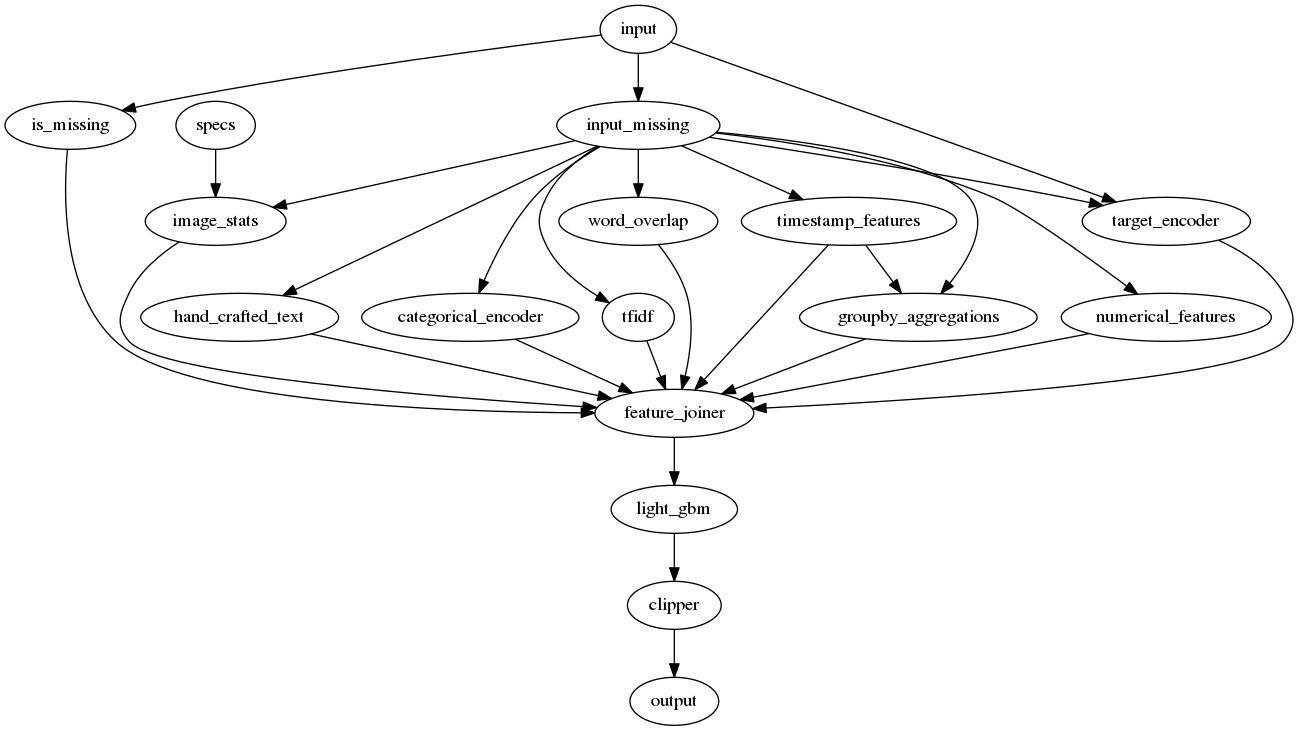

In [92]:
main(cfg.SOLUTION_CONFIG, train_mode=False)

## Feature Extraction

1. Dataframe features (train.csv)

    * numerical features - for now just the log(price) and item_seq

    * target encoded features - likelihood encoding for categorical features

    * groupby aggregations - features calculated based on aggregated categories

2. Text Features

    * Hand crafted features like len vs word count

    * Word overlap between columns like `category_name` name and `descritpion`

    * TFIDF on description and title

3. Image Features

    * Image statistics like histogram, mean var over channels, blur etc


## Models
* lightgbm with the following parameters

```yaml
  lgbm_random_search_runs: 0
  lgbm__boosting_type: 'gbdt'
  lgbm__objective: regression
  lgbm__metric: RMSE
  lgbm__number_boosting_rounds: 10000
  lgbm__early_stopping_rounds: 50
  lgbm__learning_rate: 0.2
  lgbm__num_leaves: 90
  lgbm__max_depth: 27
  lgbm__min_child_samples: 20
  lgbm__max_bin: 1300
  lgbm__subsample: 0.8
  lgbm__subsample_freq: 1
  lgbm__colsample_bytree: 0.7
  lgbm__min_child_weight: 12
  lgbm__reg_lambda: 6.0
  lgbm__reg_alpha: 3.4e-05
  lgbm__scale_pos_weight: 1

```

## Result Exploration

In [93]:
prediction_filepath = os.path.join(EXPERIMENT_DIR, 'solution_2', 'evaluation_predictions.csv')
evaluation_predictions =  pd.read_csv(prediction_filepath)

In [94]:
top_n = 100
best_predictions = evaluation_predictions.sort_values('score', ascending=True)[:top_n]
worst_predictions = evaluation_predictions.sort_values('score', ascending=False)[:top_n]

In [95]:
worst_predictions.head(3)

,item_id,user_id,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,category_name,city,description,param_1,param_2,param_3,parent_category_name,region,title,y_pred,score
300684,e808bf4c0f08,61207132e1ed,100.0,9,2017-03-25,Private,fa72ab9f0d2627da9774153e838a81e13b14d7c5289dc3...,796.0,0.0,Offer of services,Murom,"Rent a car seat Happy Baby Racing, the first d...","Transport, transportation",Special machinery,NaN,The services,Vladimir region,Rent a car seat from 0 to 4 years,0.938234,0.938234
300683,cec809358f4a,348d0459bf5e,800.0,1,2017-03-15,Private,9ac6a727e2cceb0a96362882f41e7a26494b9423ca25fe...,1080.0,0.0,Offer of services,Samara,Rent of aerial platforms for assembly of high-...,"Transport, transportation",Rent a Car,NaN,The services,Samara Region,Rent a car towers 20 meters,0.895008,0.895008
300682,4b213a1b2c3b,d9dd82600284,100.0,32,2017-03-23,Company,b6ffbe3e9a203e192320daa6540d0a860e210156739fce...,1155.0,1.0,Offer of services,Rostov-na-Donu,"Home cooking, first, second dishes, homemade c...","Meals, catering",NaN,NaN,The services,Rostov region,Delicious meals,0.122969,0.877031


## Model exploration

In [96]:
model_filepath = os.path.join(EXPERIMENT_DIR, 'solution_2', 'transformers','light_gbm')
light_gbm_model = joblib.load(model_filepath)


### Learning Curve

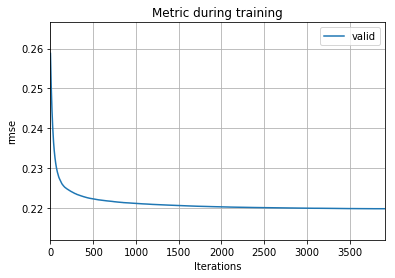

In [97]:
ax = lgb.plot_metric(light_gbm_model['evals_result'], metric='rmse')
plt.show()

### Feature Importance

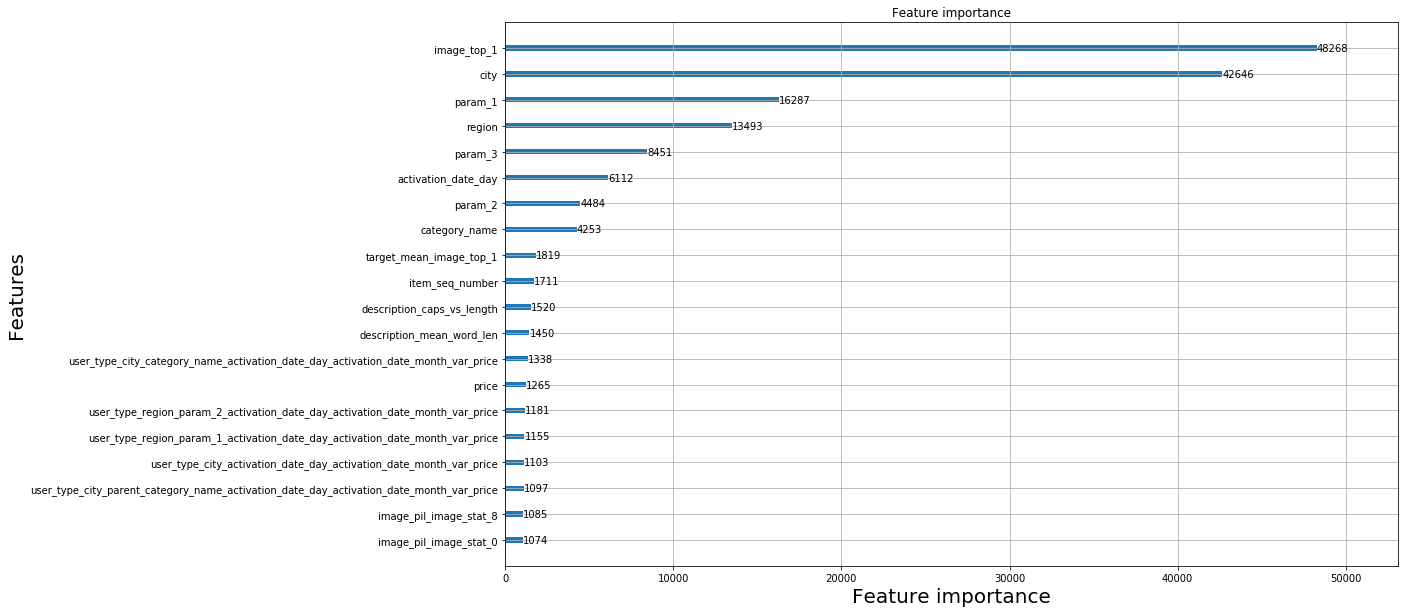

In [108]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
lgb.plot_importance(light_gbm_model['estimator'], max_num_features=20, ax=ax)
plt.show()